## Assignment 2

### Problem 1

1. Write a function that, given a data set $(X, y)$, a feature $j$, and a split point $s$, determines its associated MSE.

2. Write a function that, given a data set $(X, y)$ and feature $j$ computes the split point $s$ leading to the smallest MSE.

3. Write a function that, given a data set $(X, y)$ computes the feature/split point pair $(j, s)$ leading to the smallest MSE.

4. Test your functions by computing the first feature/split point pair for a few random training subsets of the diabetes data set using both your function and `DecisionTreeRegressor` from scikit-learn.

In [99]:
def mse_from_feature_and_split(X, y, j, s):
    X_j = X[:,j]   #   Defining feature j from X.
    
    #   Split y values according to the split of X at s.
    y_L = y[X_j <= s]
    y_R = y[X_j > s]
    
    mse = len(y_L) / len(y) * np.mean (np.square (y_L - y_L.mean ())) + len(y_R) / len(y) * np.mean (np.square (y_R - y_R.mean ()))
    #   Determine the MSE of the two nodes at split s for feature j.
    
    return mse


def split_from_feature(X, y, j):
    X_j = X[:,j]   #   Defining feature j from X.
    
    ss = np.linspace (min (X_j), max (X_j), num = 100, endpoint = False)
    #   Possible split values, s, for feature j.
    
    mses = []   #   List of MSE values for each split value, s, in ss.
    
    for s in ss:
        mse = mse_from_feature_and_split (X, y, j, s)
        #   Calculating the MSE of the possible values of s from ss.
        
        mses.append (mse)
    
    s_opt_for_j = ss[np.argmin (mses)]   #   Determining which split value, s, has the smallest MSE.
    
    return s_opt_for_j, min (mses)
    #   mses is being returned because it is needed for the next function.


def feature_split_pair(X, y):
    mses_by_j = []   #   List of MSE values according to the feature, j.
    
    ss_by_j = []   #   List of split values for each feature j.
    
    ###   The shape of X gives the number of rows and the number of columns (number of features) of the 
    ###   dataset. 
    
    ###   The features of X are labeled according to the column numbers. Since the for loop will loop through
    ###   the range 0-N, the values of j and s will be ordered in the lists mses_by_j and ss_by_j according 
    ###   to the feature label in X. 
    for j in range (X.shape[1]):
        s_opt_for_j, mse_for_s_j = split_from_feature (X, y, j)
        
        
        ss_by_j.append (s_opt_for_j)
    
            
        mses_by_j.append (mse_for_s_j)
        
#     print(ss_by_j)
#     print (mses_by_j)
    
    j_opt = np.argmin (mses_by_j)   #   find the index of the smallest MSE for the feature number j.
    #   Because the order of the entries in mse_by_j align with the order of the features in X, the indexes
    #   of the entries correspond to the features, j, of the dataset.
    
    s_opt = ss_by_j[j_opt]   #   this should work and then we don't need the one above.
    
    return j_opt, s_opt

In [100]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error
import pandas as pd

In [101]:
diabetes_data = load_diabetes ()

dia_y = diabetes_data.target
dia_X = diabetes_data.data

In [102]:
predictions = []   #   List of the feature/split point pairs (j, s), for the function created above and 
                   #   the DecisionTreeRegressor function from sklearn.


for i in range (10):   #   10 tests of the created and sklearn functions.
    dia_X_tr, dia_X_te, dia_y_tr, dia_y_te = train_test_split (dia_X, dia_y, test_size = 0.2)
    
    #   Predicted featrue and split point from the function created above.
    pre_j, pre_s = feature_split_pair (dia_X_tr, dia_y_tr)
    
    #   Prediction from the sklearn decision tree function.
    M1 = DecisionTreeRegressor (max_depth = 1)   #   Using max_depth = 1 gives the split from the root node.
    M1.fit (dia_X_tr, dia_y_tr)
    
    skl_pre_j = M1.tree_.feature[0]   #   Gives the the feature for the split
    skl_pre_s = M1.tree_.threshold[0]   #   Gives the split value.
    
    predictions.append ((pre_j, pre_s, skl_pre_j, skl_pre_s))
    

summary = pd.DataFrame (predictions, columns = ['Feature, j', 'Split, s', 'Feature, j - skl', 'Split, s - skl'])
display (summary)

,"Feature, j","Split, s","Feature, j - skl","Split, s - skl"
0,8,-0.004420,8,-0.003762
1,8,-0.004040,8,-0.003762
2,8,-0.001443,8,-0.000169
3,8,-0.004040,8,-0.003762
4,2,-0.006810,2,-0.006745
5,2,0.008840,2,0.009422
6,8,0.020683,8,0.016671
7,8,-0.001443,8,-0.000169
8,8,-0.004040,8,-0.003762
9,2,0.007665,2,0.009422


The table compares the predicted feature/split point pairs of the functions created above and the function from sklearn. The results of 10 trials on ten random training sets show that both models predicted the same feature for spliting for each trial. The split values for each model were also close, but not exact. This could be the result of how split values were generated. For the fucntion created above, 100 equally spaced values of s were generated between X_j min and X_j max, and the s with the smallest calculated MSE was returned. Sklearn may have a different method for determining values of s.

### Problem 2

The decision tree produced by fitting an instance `M` of `DecisionTreeRegressor` or `DecisionTreeClassifier` to data is stored in `M.tree_`. `M.tree_`, an instance of scikit-learn's internal `Tree` class (see below).

Write a function that takes `M.tree_` as input and return a corresponding `graphviz` graph `G`.
Label each node with its index, the feature on which it's split (for interior nodes), the splitting threshold (for interior nodes), and the regression/classification value for each leaf node.

Demonstrate your function by plotting a regression tree for the diabetes data set and a classification tree for the breast cancer data set. Set a reasonable `max_depth` so that your tree fits on the screen.

In [103]:
from graphviz import Graph

def to_graphviz(tree):
    G = Graph()
    for i in range(tree.node_count):
        if tree.feature[i] == -2:
            G.attr ('node', style = 'filled', color = 'green')
            G.node (str (i), label = f" index: {i} \n X[{tree.feature[i]}] \n split: {tree.threshold[i]:.5f} \n value: {tree.value[i][0][0]:.2f}")
        elif tree.feature[i] != -2:
            G.attr ('node', style = '', color = 'black')
            G.node (str (i), label = f" index: {i} \n X[{tree.feature[i]}] \n split: {tree.threshold[i]:.5f} \n value: {tree.value[i][0][0]:.2f}")
    for i in range(tree.node_count):
        if tree.children_left[i] == -1 or tree.children_right[i] == -1:
            continue
        else:
            G.edge (str (i), str (tree.children_left[i]))
            G.edge (str (i), str (tree.children_right[i]))
    return G

In [104]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_breast_cancer

### Regression tree for diabetes data

In [105]:
diabetes_data = load_diabetes ()

dia_y = diabetes_data.target
dia_X = diabetes_data.data

dia_X_tr, dia_X_te, dia_y_tr, dia_y_te = train_test_split (dia_X, dia_y, test_size = 0.2)

In [106]:
MR = DecisionTreeRegressor (max_depth = 2)
MR.fit (dia_X_tr, dia_y_tr)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

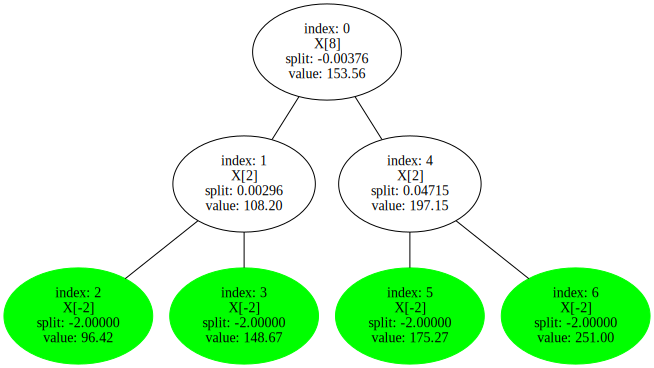

In [107]:
to_graphviz (MR.tree_)

### Classification tree for breast cancer data

In [108]:
bc_data = load_breast_cancer ()

bc_y = bc_data.target
bc_X = bc_data.data

bc_X_tr, bc_X_te, bc_y_tr, bc_y_te = train_test_split (bc_X, bc_y, test_size = 0.2)

In [109]:
MC = DecisionTreeClassifier (max_depth = 2)
MC.fit (bc_X_tr, bc_y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

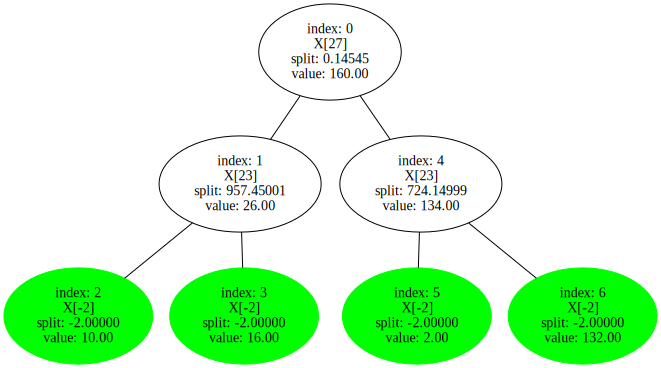

In [110]:
to_graphviz (MC.tree_)

### Optional Bonus Problem

Write a function that takes as input `M.tree_` and returns the feature importances. (You'll have to look up the precise formula for this.)

The equations for the calculations was found on 
https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3

In [111]:
def feature_importance (tree):
    
    w = tree.weighted_n_node_samples   #   the weighted number of training samples reaching node i
    
    imp = tree.impurity   #   impurity at node i
    
    feat = tree.feature   #   features split on for node i
    
    importances = []   #   list of node importances using the Gini Importance
    
    for i in range (tree.node_count):
        importance = w[i]*imp[i] - w[tree.children_left[i]]*imp[tree.children_left[i]] - w[tree.children_right[i]]*imp[tree.children_right[i]]
        #   computation of the Gini Importance for node i
        
        importances.append (importance)
    
    importances = np.array (importances)
    
    all_node_impo = sum (importances)   #   sum of all node importances
    
    feature_importance = []   #   list of the importance of each feature
   
    for j in range (tree.n_features):   #   I changed this to n_features try and see what this does to the function.
        
        importance_per_feature = sum (importances[feat == j]) / all_node_impo
        #   the importance per feature determined by the sum of the node importances for the nodes split on 
        #   feature j divided by the total node importances.
        
        feature_importance.append (importance_per_feature)
        
        
    feat_imp_nor = np.array (feature_importance) / sum (feature_importance)   #   normalisation

        
    return feat_imp_nor

In [112]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np

In [113]:
diabetes_data = load_diabetes ()

dia_y = diabetes_data.target
dia_X = diabetes_data.data

dia_X_tr, dia_X_te, dia_y_tr, dia_y_te = train_test_split (dia_X, dia_y, test_size = 0.2)

#### Decision tree regressor on diabetes dataset

In [114]:
M = DecisionTreeRegressor (max_depth = 5)
M.fit (dia_X_tr, dia_y_tr)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [115]:
print (f'According to the in-built function, the feature importances are:')
display (M.feature_importances_)

print (f'For the function above, the feature imporances are:')
display (feature_importance (M.tree_))

According to the in-built function, the feature importances are:


array([0.04028479, 0.        , 0.25462601, 0.07110936, 0.01570715,
       0.04160721, 0.        , 0.02536238, 0.46596223, 0.08534088])

For the function above, the feature imporances are:


array([0.04028479, 0.        , 0.25462601, 0.07110936, 0.01570715,
       0.04160721, 0.        , 0.02536238, 0.46596223, 0.08534088])

In [116]:
display (M.feature_importances_.argsort ())
display (feature_importance (M.tree_).argsort ())

array([1, 6, 4, 7, 0, 5, 3, 9, 2, 8])

array([1, 6, 4, 7, 0, 5, 3, 9, 2, 8])

The built function, above, and the attribute built-in to sklearn produce the same results.

#### Decision tree classifier on diabetes dataset

In [117]:
M = DecisionTreeClassifier (max_depth = 3)
M.fit (dia_X_tr, dia_y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [118]:
print (f'According to the in-built function, the feature importances are:')
display (M.feature_importances_)

print (f'For the function above, the feature imporances are:')
display (feature_importance (M.tree_))

According to the in-built function, the feature importances are:


array([0.        , 0.12711456, 0.16093153, 0.1747253 , 0.1239864 ,
       0.        , 0.41324221, 0.        , 0.        , 0.        ])

For the function above, the feature imporances are:


array([0.        , 0.12711456, 0.16093153, 0.1747253 , 0.1239864 ,
       0.        , 0.41324221, 0.        , 0.        , 0.        ])

In [119]:
display (M.feature_importances_.argsort ())
display (feature_importance (M.tree_).argsort ())

array([0, 5, 7, 8, 9, 4, 1, 2, 3, 6])

array([0, 5, 7, 8, 9, 4, 1, 2, 3, 6])

The built function, above, and the attribute parameter built-in to sklearn produce the same result.

In [120]:
#M.tree_?
#help (M.tree_)